# **Unsupervised - SetNo2**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set the working Directory

In [4]:
import os
working_directory = "/content/drive/MyDrive/00000000_FIVERR/datanalyst_28/NabeelHaiderProject"
os.chdir(working_directory)

**Set No. 2**

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | February 12, 2004 10:32:39 to February 19, 2004 06:22:39                                |
| No. of Files:            | 984                                                                                     |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 1. |

Import Required Modules

In [5]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")
sns.set(color_codes=True)
%matplotlib inline

Load Data File for Test 2, Merged

In [93]:
merged_data = pd.read_csv('ProcessedData/MergedData/DatasetBearingTest_2.csv')
merged_data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
merged_data.time = pd.to_datetime(merged_data['time'], format='%Y-%m-%d %H:%M:%S')
merged_data.index=merged_data['time']
merged_data = merged_data.sort_index()
merged_data.drop(columns=['time'], inplace=True)
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


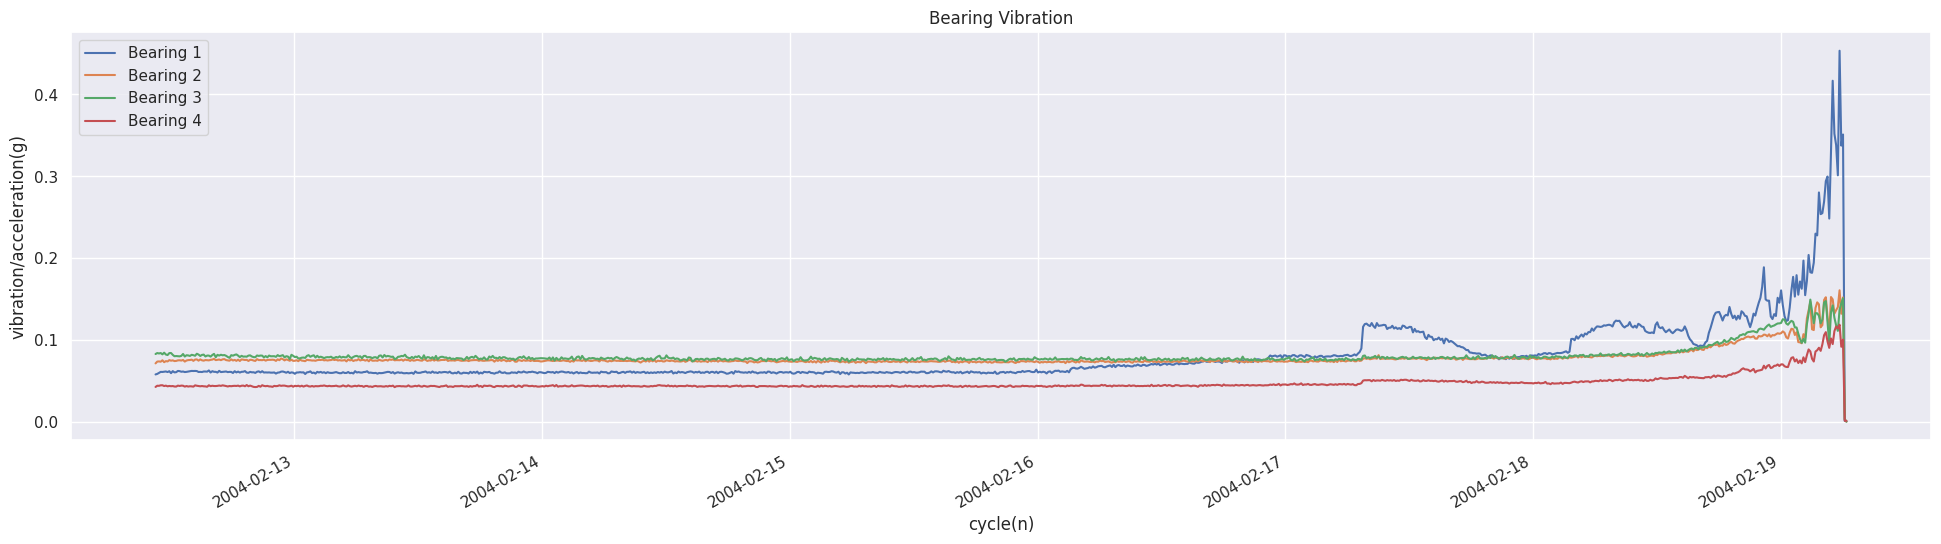

In [94]:
ax = merged_data.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

Split Data into Train and Test

In [95]:
split_index = int(0.7 * len(merged_data))

In [96]:
train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

Normalize Data

In [97]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
X_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

Isolation Forest

In [98]:
iso_forest = IsolationForest(n_estimators=1000, contamination='auto', random_state=42)
iso_forest.fit(X_train)

IsolationForest(n_estimators=1000, random_state=42)

Get anomaly scores and predictions for the train and test data

In [99]:
# Get anomaly scores and predictions for the train and test data
train_scores = iso_forest.decision_function(X_train)
train_anomalies = iso_forest.predict(X_train)
test_scores = iso_forest.decision_function(X_test)
test_anomalies = iso_forest.predict(X_test)

In [100]:
iso_forest_results = pd.DataFrame(index=X_train.index.append(X_test.index))
iso_forest_results['Score'] = np.concatenate([train_scores, test_scores])
iso_forest_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [101]:
iso_forest_results['Anomaly'] = iso_forest_results['Anomaly'] == -1

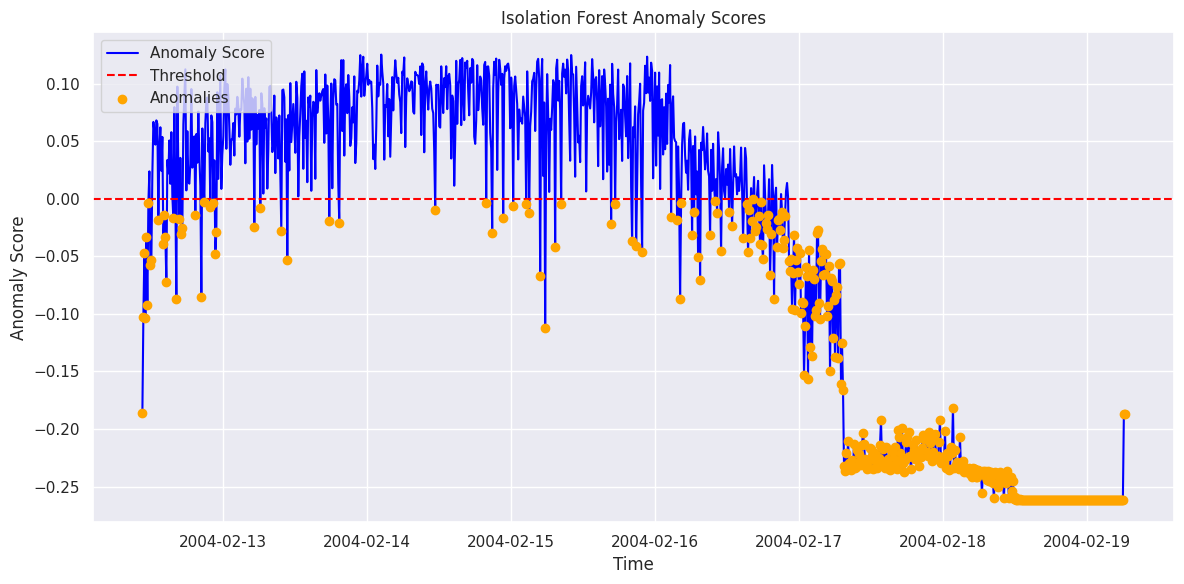

In [102]:
plt.figure(figsize=(12,6))
plt.plot(iso_forest_results.index, iso_forest_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(iso_forest_results[iso_forest_results['Anomaly']].index,
            iso_forest_results[iso_forest_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

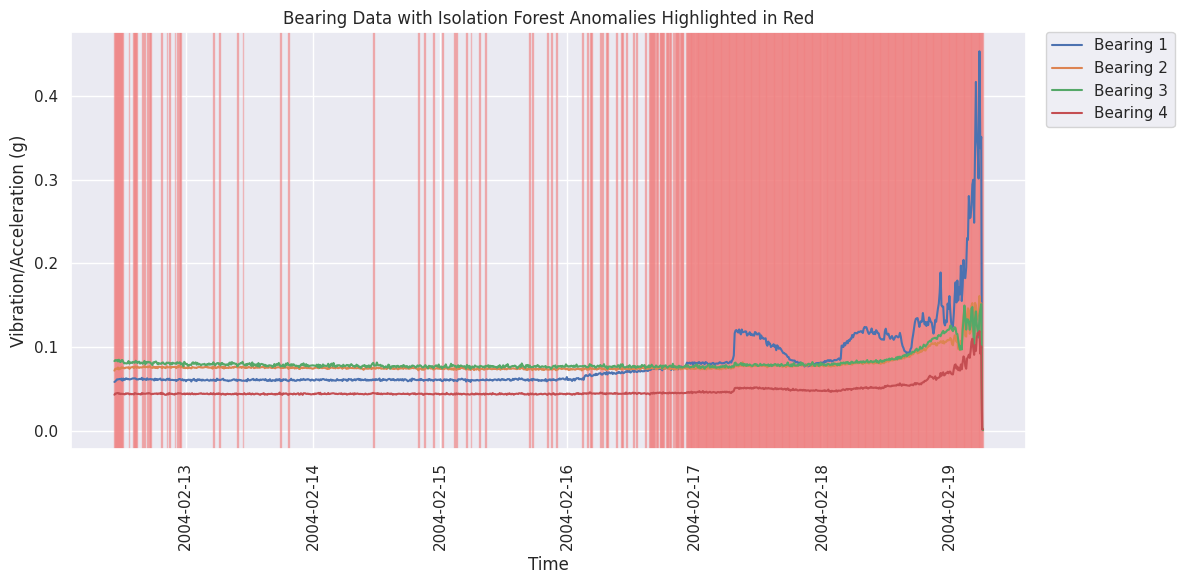

In [103]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

It is Detecting TOO uch ANOMALIES, So, we will move to Experimenting further.

In [104]:
#set contamination to a lower value, e.g., 0.01 (1% of the data)
iso_forest = IsolationForest(n_estimators=200, contamination=0.009, random_state=42)
iso_forest.fit(X_train)

train_scores = iso_forest.decision_function(X_train)
train_anomalies = iso_forest.predict(X_train)
test_scores = iso_forest.decision_function(X_test)
test_anomalies = iso_forest.predict(X_test)

iso_forest_results = pd.DataFrame(index=X_train.index.append(X_test.index))
iso_forest_results['Score'] = np.concatenate([train_scores, test_scores])
iso_forest_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])
iso_forest_results['Anomaly'] = iso_forest_results['Anomaly'] == -1

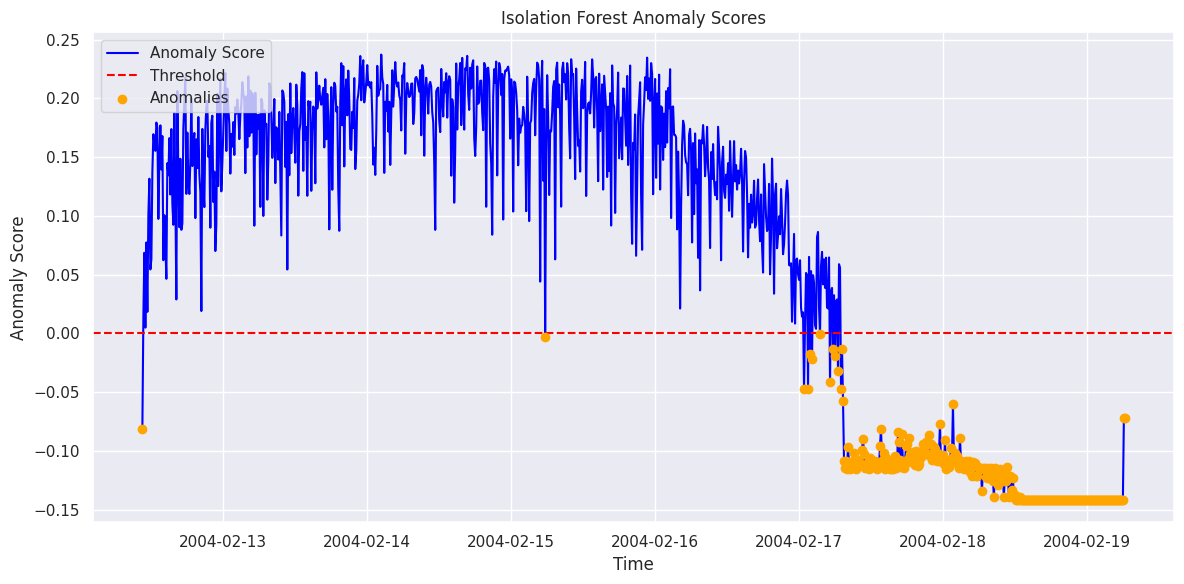

In [105]:
plt.figure(figsize=(12,6))
plt.plot(iso_forest_results.index, iso_forest_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(iso_forest_results[iso_forest_results['Anomaly']].index,
            iso_forest_results[iso_forest_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

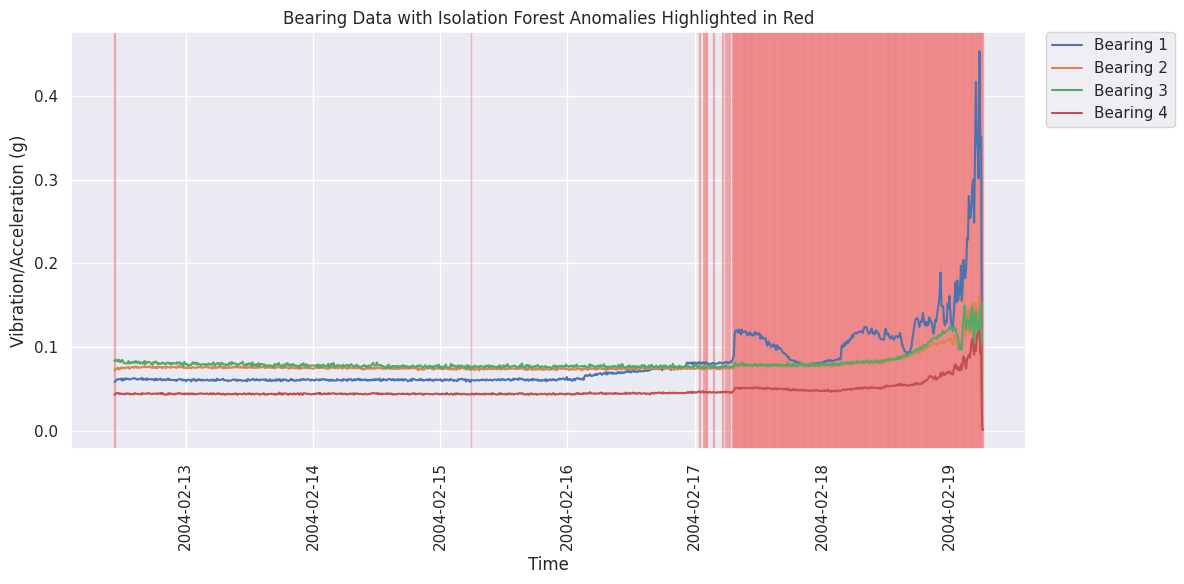

In [106]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Isolation Forest Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Lets test with a number of contamination values

In [107]:
contamination_values = [0.005, 0.01, 0.02, 0.05]

for contamination in contamination_values:
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso_forest.fit(X_train)
    total_anomalies = sum(iso_forest.predict(X_test) == -1)
    print(f"Contamination: {contamination}, Total Anomalies Detected: {total_anomalies}")

Contamination: 0.005, Total Anomalies Detected: 286
Contamination: 0.01, Total Anomalies Detected: 287
Contamination: 0.02, Total Anomalies Detected: 290
Contamination: 0.05, Total Anomalies Detected: 294


Adjust n_estimators and max_samples

In [108]:
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    random_state=42
)
iso_forest.fit(X_train)

IsolationForest(n_estimators=200, random_state=42)

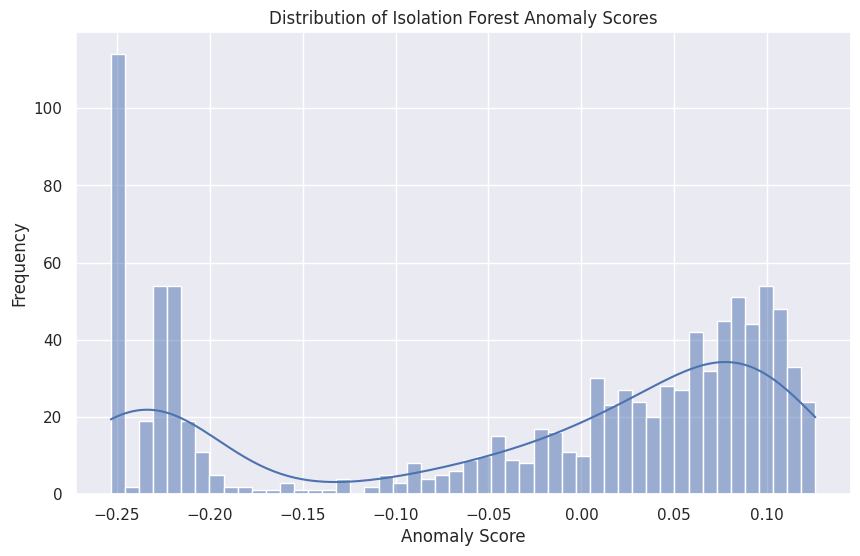

In [109]:
#calculate anomaly scores
scores = iso_forest.decision_function(pd.concat([X_train, X_test]))

#plot the distribution of scores
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [110]:
threshold = np.percentile(scores, 30)
print(f"Custom Threshold: {threshold}")

Custom Threshold: -0.11240410989713412


In [111]:
iso_forest_results['Anomaly_Custom'] = iso_forest_results['Score'] < threshold

Plotting with Adjusted Anomalies

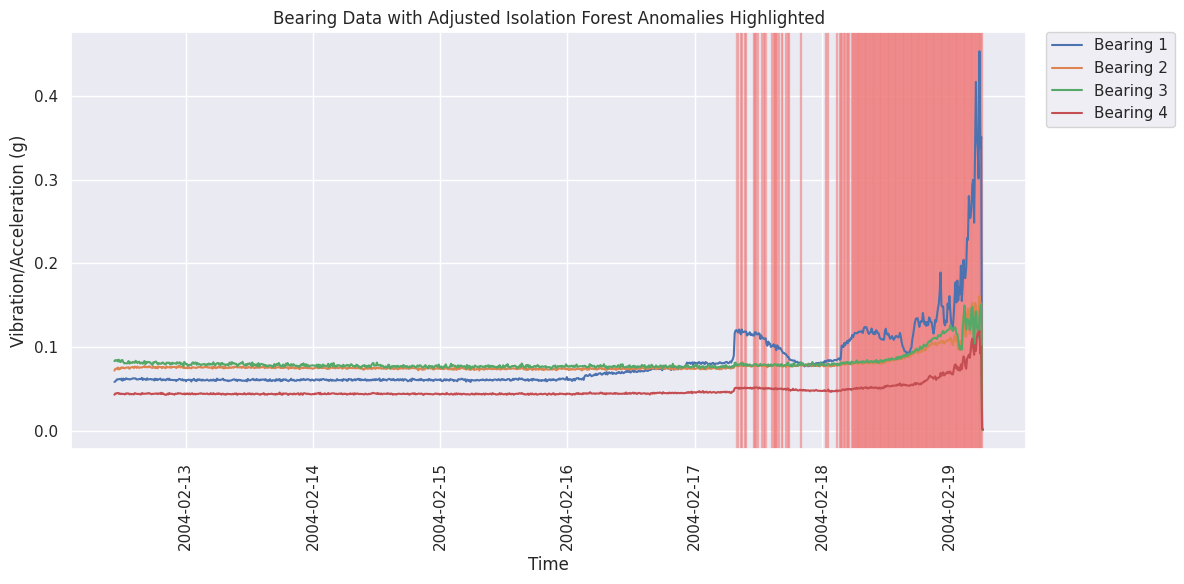

In [112]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted Isolation Forest Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [113]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Anomaly_ISO
time,,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067,False
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541,False
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,False
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,False
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,False
...,...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047,True
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125,True
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817,True


This is better and has identified the anomalies, better.

# **One-Class SVM**

In [129]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train)

OneClassSVM(gamma='auto', nu=0.05)

In [130]:
train_scores = ocsvm.decision_function(X_train)
train_anomalies = ocsvm.predict(X_train)
test_scores = ocsvm.decision_function(X_test)
test_anomalies = ocsvm.predict(X_test)

In [131]:
ocsvm_results = pd.DataFrame(index=X_train.index.append(X_test.index))
ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

#anomalies are marked as -1, normal as 1
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

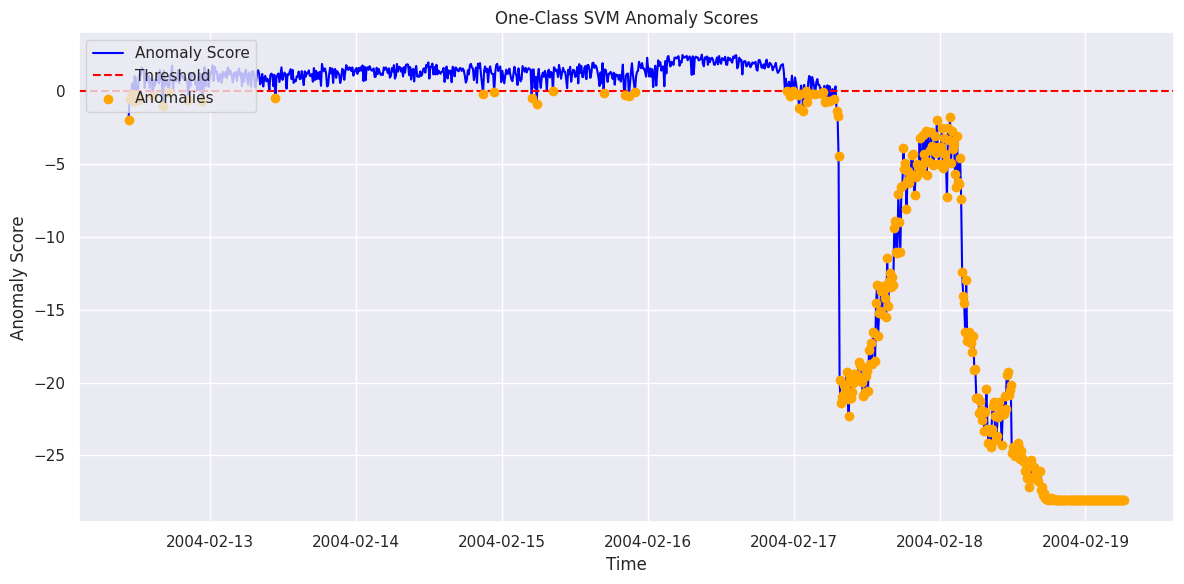

In [132]:
plt.figure(figsize=(12,6))
plt.plot(ocsvm_results.index, ocsvm_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(ocsvm_results[ocsvm_results['Anomaly']].index,
            ocsvm_results[ocsvm_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

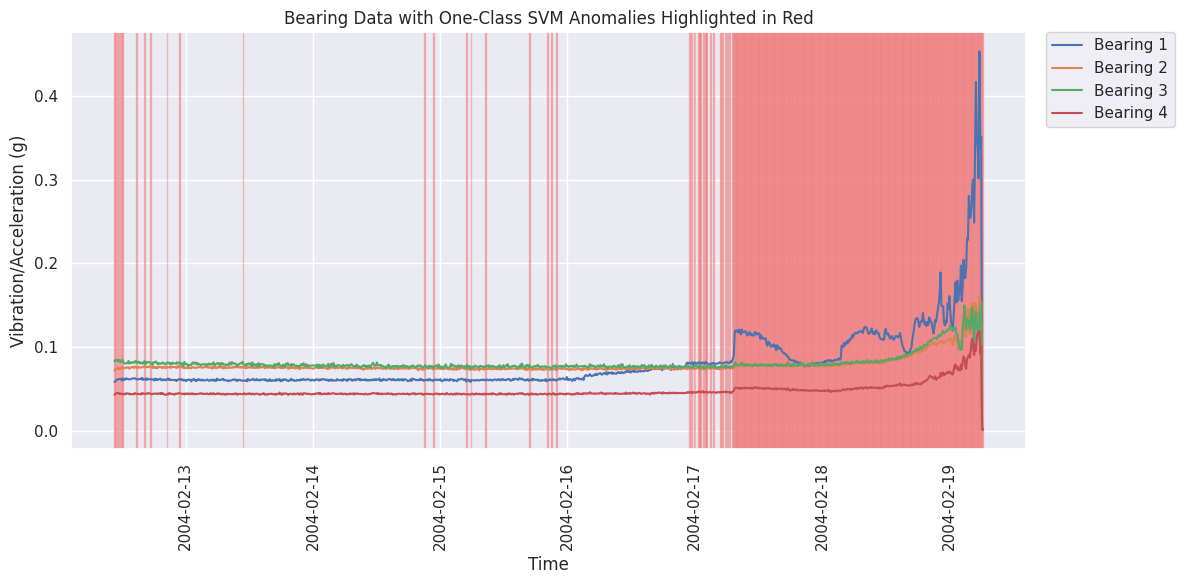

In [133]:
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with One-Class SVM Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

this is getting a whole lot of anoalies, so it needs to be adjusted as well.

Adjust the nu Parameter

In [134]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.005)  #try nu = 0.005 or even lower
ocsvm.fit(X_train)

train_scores = ocsvm.decision_function(X_train)
train_anomalies = ocsvm.predict(X_train)
test_scores = ocsvm.decision_function(X_test)
test_anomalies = ocsvm.predict(X_test)

combined_index = X_train.index.append(X_test.index)
ocsvm_results = pd.DataFrame(index=combined_index)
ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

# Convert predictions: anomalies are marked as -1
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

ocsvm_results['Score'] = np.concatenate([train_scores, test_scores])
ocsvm_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])
ocsvm_results['Anomaly'] = ocsvm_results['Anomaly'] == -1

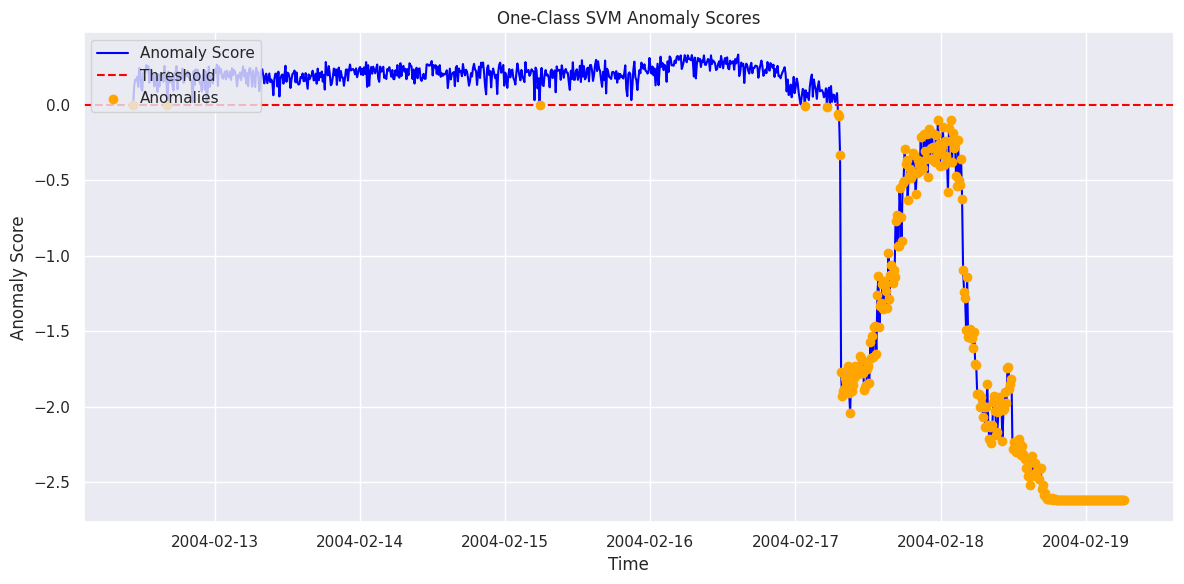

In [135]:
plt.figure(figsize=(12,6))
plt.plot(ocsvm_results.index, ocsvm_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(ocsvm_results[ocsvm_results['Anomaly']].index,
            ocsvm_results[ocsvm_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('One-Class SVM Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

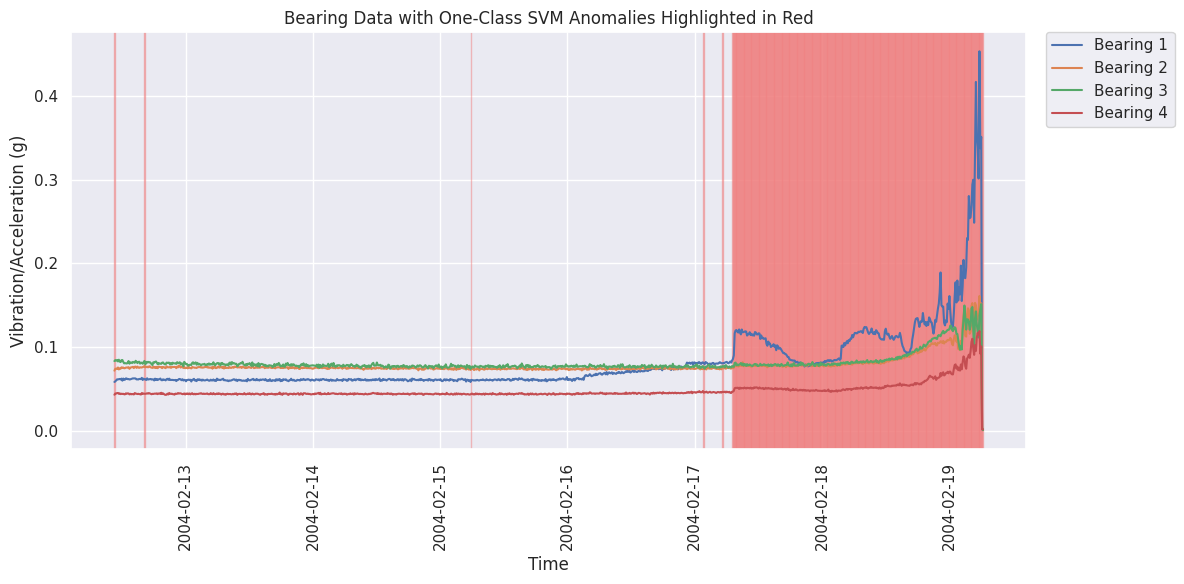

In [136]:
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with One-Class SVM Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Test other Gamma

In [137]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.005)
ocsvm.fit(X_train)

OneClassSVM(gamma=0.01, nu=0.005)

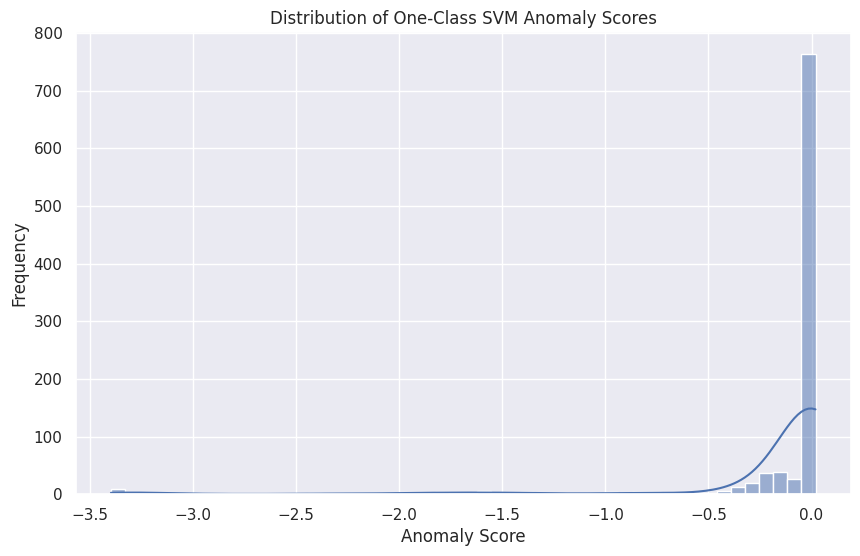

In [138]:
#calculate anomaly scores
scores = ocsvm.decision_function(pd.concat([X_train, X_test]))

#distribution of scores
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of One-Class SVM Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [145]:
threshold = np.percentile(scores, 25)
print(f"Custom Threshold: {threshold}")
ocsvm_results['Anomaly_Custom'] = ocsvm_results['Score'] < threshold
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly_Custom'].values

Custom Threshold: -0.024248496813320308


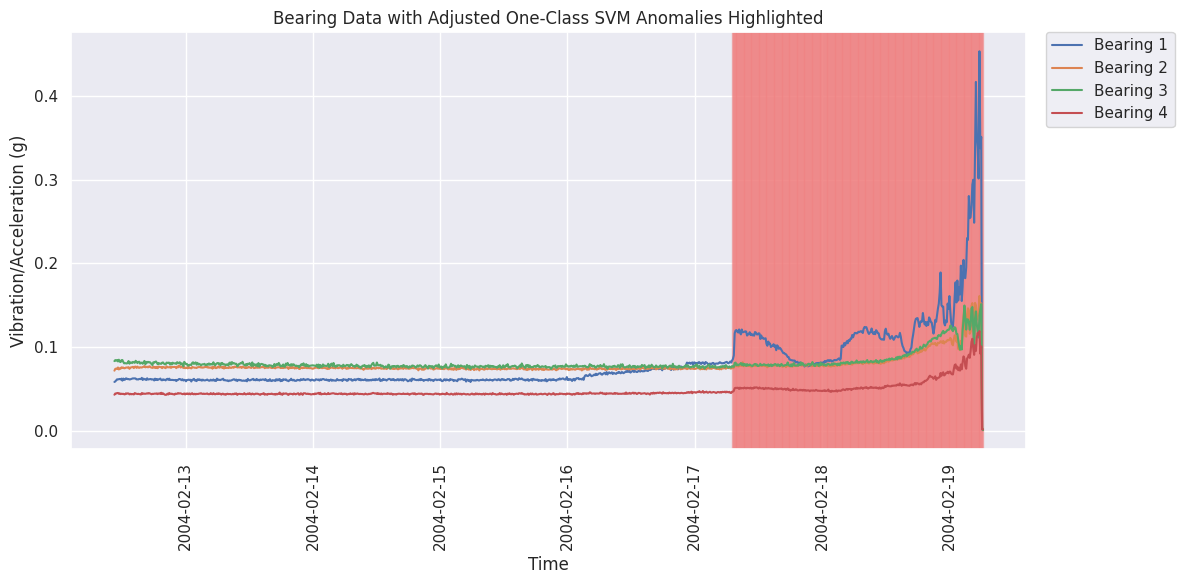

In [146]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-2]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted One-Class SVM Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

this look better.

# **Local Outlier Factor (LOF)**

In [147]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
lof.fit(X_train)

LocalOutlierFactor(novelty=True)

In [148]:
train_scores = lof.decision_function(X_train)
train_anomalies = lof.predict(X_train)
test_scores = lof.decision_function(X_test)
test_anomalies = lof.predict(X_test)

lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = np.concatenate([train_scores, test_scores])
lof_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [149]:
lof_results['Anomaly'] = lof_results['Anomaly'] == -1

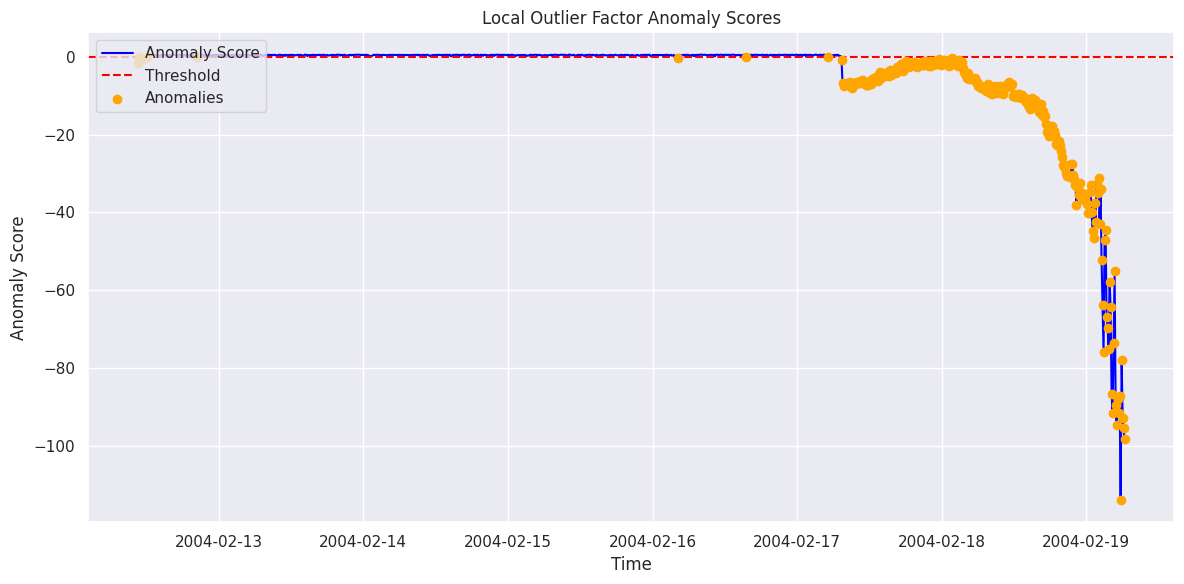

In [150]:
plt.figure(figsize=(12,6))
plt.plot(lof_results.index, lof_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(lof_results[lof_results['Anomaly']].index,
            lof_results[lof_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

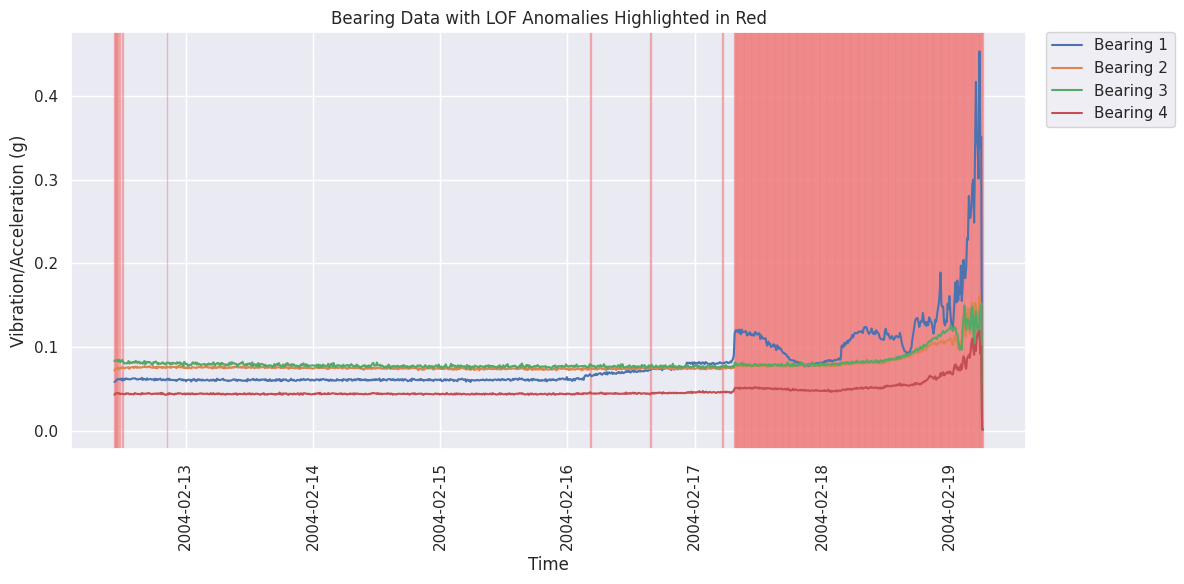

In [152]:
merged_data['Anomaly_LOF'] = lof_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with LOF Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Need to Optimise it as Well. This is also detecting TOO much ANOMALIES

Adjust the contamination Parameter

In [153]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)
lof.fit(X_train)
train_scores = lof.decision_function(X_train)
test_scores = lof.decision_function(X_test)

train_anomalies = lof.predict(X_train)
test_anomalies = lof.predict(X_test)

In [154]:
lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = np.concatenate([train_scores, test_scores])
lof_results['Anomaly'] = np.concatenate([train_anomalies, test_anomalies])

In [155]:
lof_results['Anomaly'] = lof_results['Anomaly'] == -1

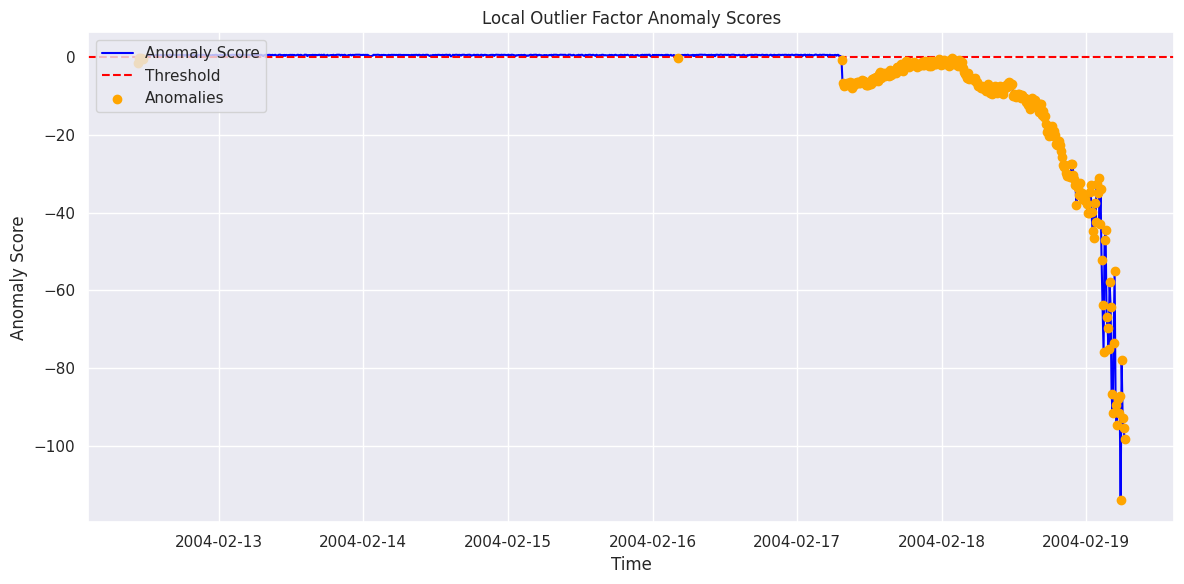

In [156]:
plt.figure(figsize=(12,6))
plt.plot(lof_results.index, lof_results['Score'], label='Anomaly Score', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold')
plt.scatter(lof_results[lof_results['Anomaly']].index,
            lof_results[lof_results['Anomaly']]['Score'],
            color='orange', label='Anomalies', zorder=5)
plt.title('Local Outlier Factor Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

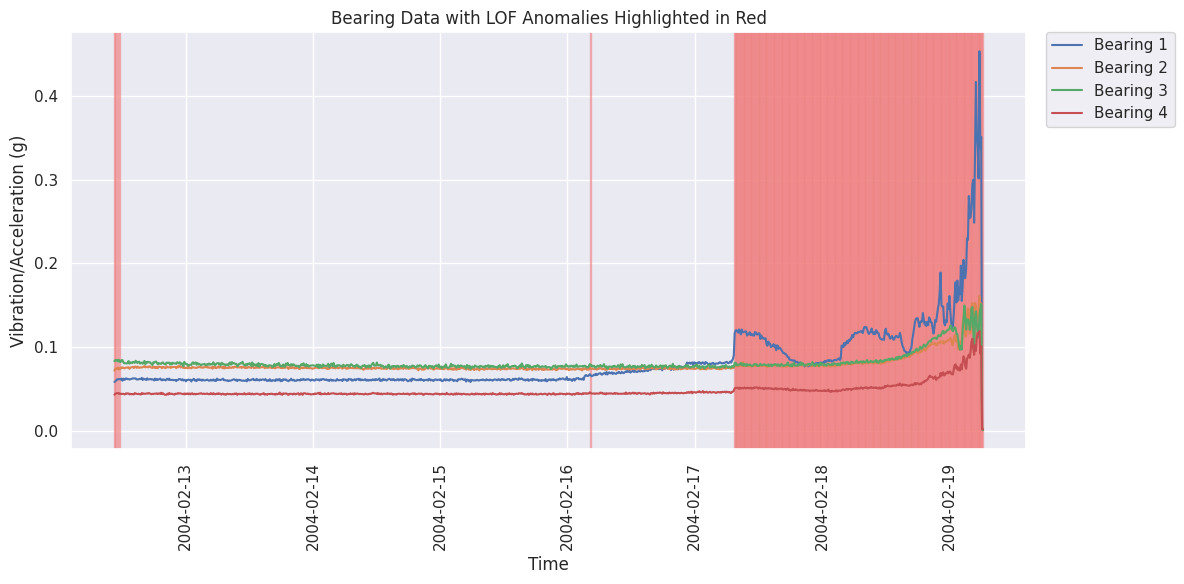

In [157]:
merged_data['Anomaly_LOF'] = lof_results['Anomaly']

plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with LOF Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Adjust the n_neighbors Parameter

In [158]:
lof = LocalOutlierFactor(n_neighbors=35, contamination=0.01, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.01, n_neighbors=35, novelty=True)

In [159]:
train_scores = lof.decision_function(X_train)
test_scores = lof.decision_function(X_test)

train_anomalies = lof.predict(X_train)
test_anomalies = lof.predict(X_test)

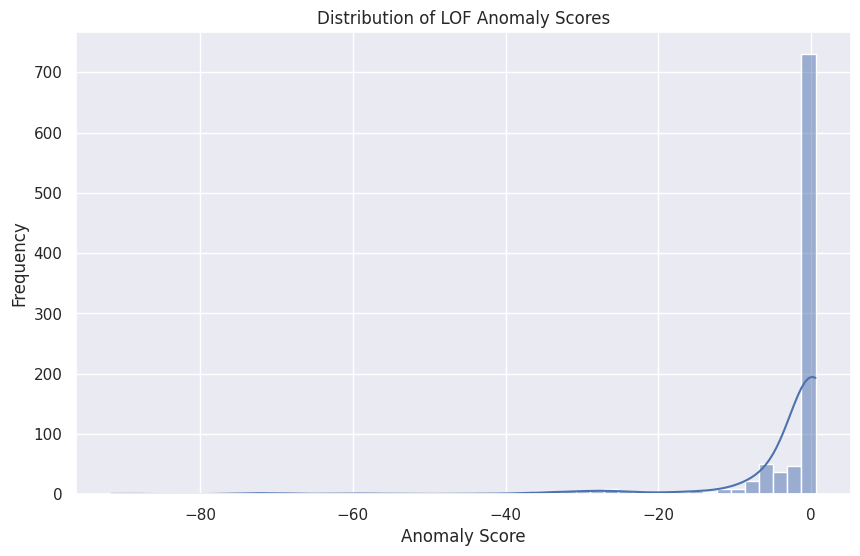

In [160]:
scores = np.concatenate([train_scores, test_scores])
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of LOF Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [178]:
threshold = np.percentile(scores, 25)
print(f"Custom Threshold: {threshold}")

Custom Threshold: -1.3744022527784945


In [179]:
lof_results = pd.DataFrame(index=X_train.index.append(X_test.index))
lof_results['Score'] = scores
lof_results['Anomaly'] = scores < threshold

merged_data['Anomaly_LOF'] = lof_results['Anomaly'].values

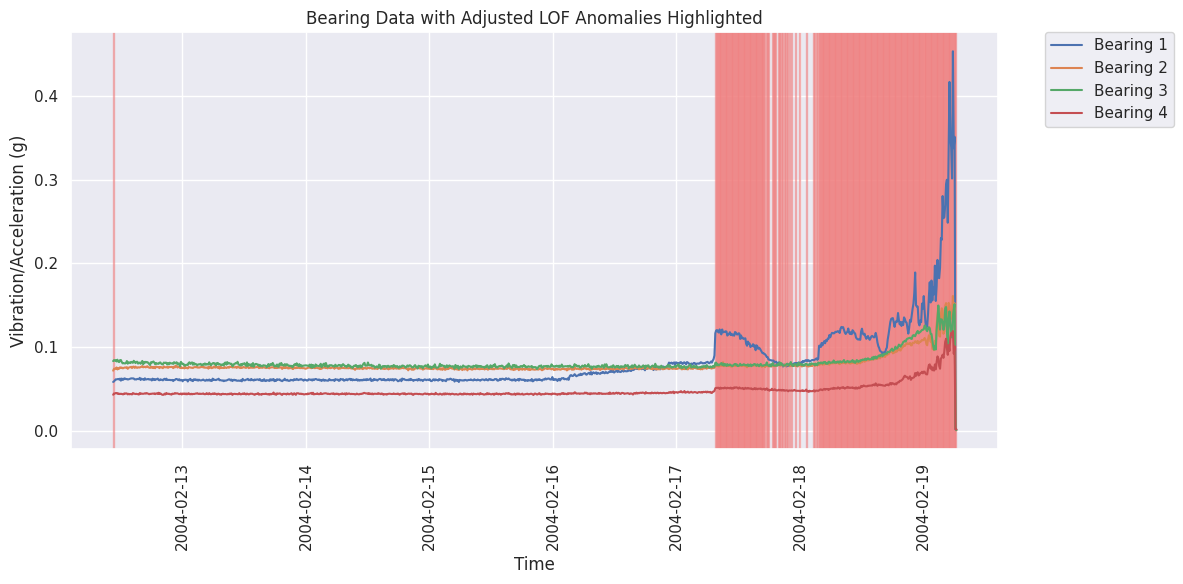

In [180]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-3]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Adjusted LOF Anomalies Highlighted")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


This looks better and is detecting anomalies at the end.

In [168]:
contamination_values = [0.005, 0.01, 0.02]
n_neighbors_values = [20, 35, 50]

for contamination in contamination_values:
    for n_neighbors in n_neighbors_values:
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)
        lof.fit(X_train)
        test_anomalies = lof.predict(X_test)
        n_anomalies = np.sum(test_anomalies == -1)
        print(f"Contamination: {contamination}, n_neighbors: {n_neighbors}, Anomalies Detected: {n_anomalies}")

Contamination: 0.005, n_neighbors: 20, Anomalies Detected: 283
Contamination: 0.005, n_neighbors: 35, Anomalies Detected: 282
Contamination: 0.005, n_neighbors: 50, Anomalies Detected: 281
Contamination: 0.01, n_neighbors: 20, Anomalies Detected: 283
Contamination: 0.01, n_neighbors: 35, Anomalies Detected: 283
Contamination: 0.01, n_neighbors: 50, Anomalies Detected: 283
Contamination: 0.02, n_neighbors: 20, Anomalies Detected: 285
Contamination: 0.02, n_neighbors: 35, Anomalies Detected: 283
Contamination: 0.02, n_neighbors: 50, Anomalies Detected: 283


In [169]:
merged_data['Anomaly_ISO'] = iso_forest_results['Anomaly_Custom'].values
merged_data['Anomaly_OCSVM'] = ocsvm_results['Anomaly_Custom'].values
merged_data['Anomaly_LOF'] = lof_results['Anomaly'].values

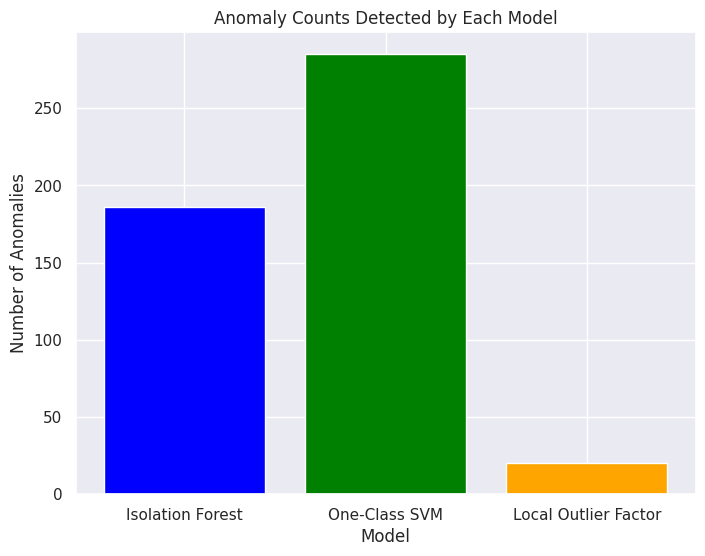

In [170]:
# Plot 1: Anomaly counts detected by each model (bar plot)
anomalies_iso = merged_data['Anomaly_ISO'].sum()
anomalies_ocsvm = merged_data['Anomaly_OCSVM'].sum()
anomalies_lof = merged_data['Anomaly_LOF'].sum()

plt.figure(figsize=(8, 6))
models = ['Isolation Forest', 'One-Class SVM', 'Local Outlier Factor']
anomaly_counts = [anomalies_iso, anomalies_ocsvm, anomalies_lof]
plt.bar(models, anomaly_counts, color=['blue', 'green', 'orange'])
plt.title('Anomaly Counts Detected by Each Model')
plt.xlabel('Model')
plt.ylabel('Number of Anomalies')
plt.show()

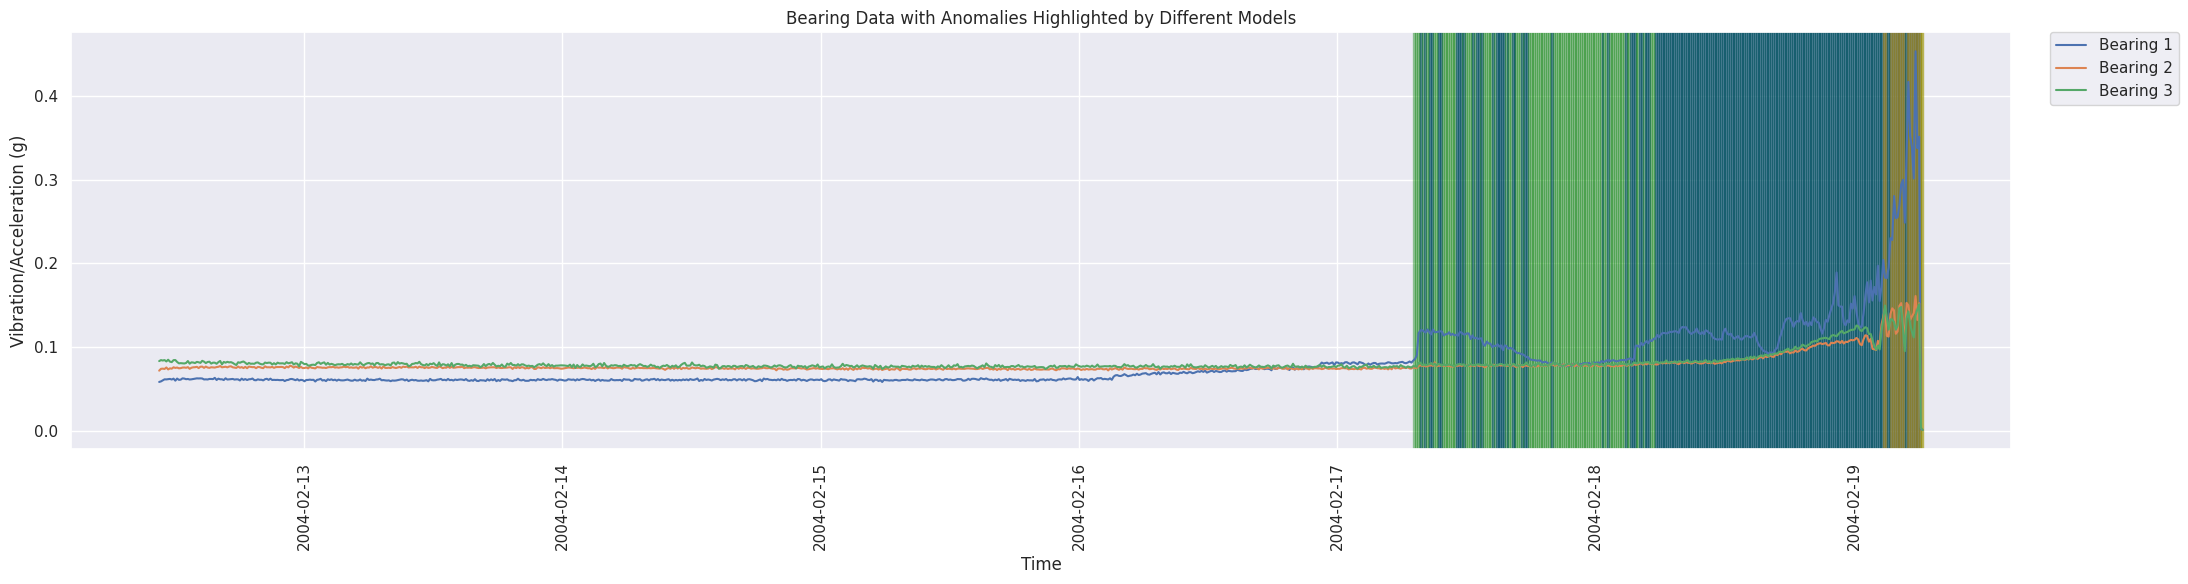

In [171]:
#Time series plot of vibration/acceleration data with anomalies highlighted

plt.figure(figsize=(22, 6))
for col in merged_data.columns[:-4]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data) - 1):
    if merged_data['Anomaly_ISO'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='blue', alpha=0.3, label="ISO Forest Anomaly" if i == 0 else "")
    if merged_data['Anomaly_OCSVM'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='green', alpha=0.3, label="OCSVM Anomaly" if i == 0 else "")
    if merged_data['Anomaly_LOF'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='orange', alpha=0.3, label="LOF Anomaly" if i == 0 else "")

plt.title("Bearing Data with Anomalies Highlighted by Different Models")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

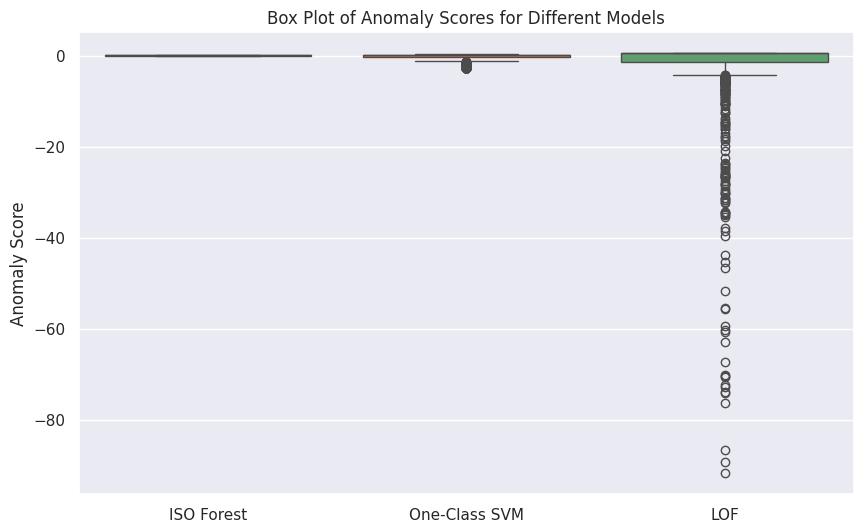

In [181]:
comparison_df = pd.DataFrame({
    'ISO Forest': iso_forest_results['Score'],
    'One-Class SVM': ocsvm_results['Score'],
    'LOF': lof_results['Score']
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=comparison_df)
plt.title('Box Plot of Anomaly Scores for Different Models')
plt.ylabel('Anomaly Score')
plt.show()

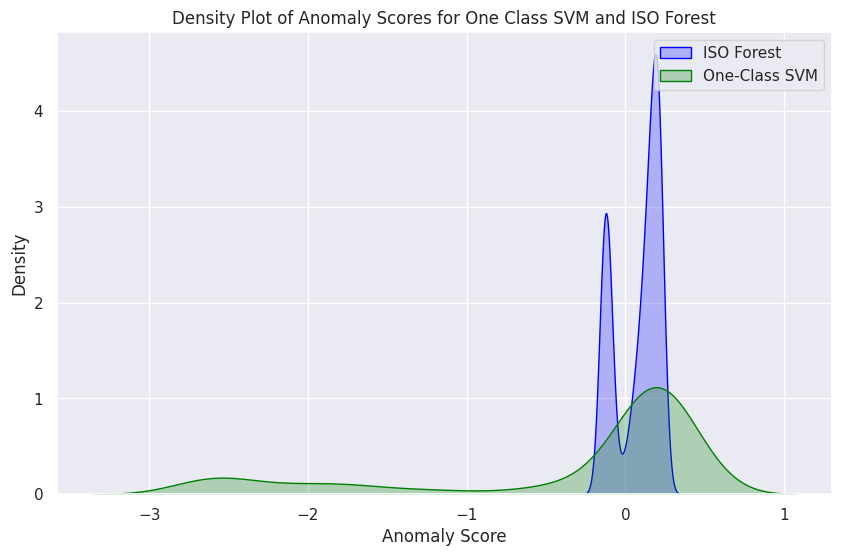

In [182]:
plt.figure(figsize=(10, 6))
sns.kdeplot(iso_forest_results['Score'], label='ISO Forest', color='blue', shade=True)
sns.kdeplot(ocsvm_results['Score'], label='One-Class SVM', color='green', shade=True)
plt.title('Density Plot of Anomaly Scores for One Class SVM and ISO Forest')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.legend()
plt.show()

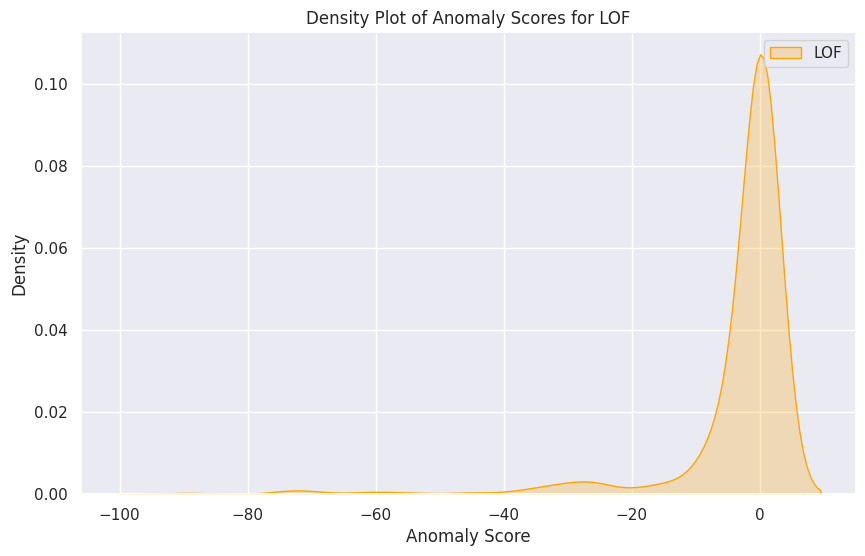

In [183]:
plt.figure(figsize=(10, 6))
sns.kdeplot(lof_results['Score'], label='LOF', color='orange', shade=True)
plt.title('Density Plot of Anomaly Scores for LOF')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.legend()
plt.show()